<a href="https://colab.research.google.com/github/rachelkim0205/TeamProject/blob/main/QQQ_stock_marcket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Adding sentiment score by web scraping (News would be better)  
2. Upgrade models  
3. Add accuracy score, + (add some scores of our models)  

# Stock Price(QQQ) Prediction Project

QQQ is an ETF tracking the NASDAQ-100 Index, bundling major U.S. tech stocks like Apple and Tesla.  
With over 50% weighting in the tech sector, it directly mirrors the growth trajectory of technology industries.  
While highly volatile due to its tech concentration, it has historically delivered strong long-term returns (~15% annual average).   
Short-term performance remains sensitive to interest rate changes and macroeconomic conditions.  

For our price prediction project, we'll focus on analyzing tech trends, earnings reports, and Fed policies as key variables.

## 1. Libraries & APIs

https://www.kaggle.com/code/carlmcbrideellis/lstm-time-series-stock-price-prediction-fail

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from matplotlib.pylab import rcParams
import seaborn as sns
from numpy.random import seed
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:
## Stock dataset install

!pip -q install yfinance
import yfinance as yf

In [ ]:
pip show yfinance

Name: yfinance
Version: 0.2.55
Summary: Download market data from Yahoo! Finance API
Home-page: https://github.com/ranaroussi/yfinance
Author: Ran Aroussi
Author-email: ran@aroussi.com
License: Apache
Location: /usr/local/lib/python3.11/dist-packages
Requires: beautifulsoup4, frozendict, multitasking, numpy, pandas, peewee, platformdirs, pytz, requests
Required-by: 


## 2. Load Data

In this project, the goal is short-term prediction, and to avoid overfitting, it was determined that using 5 years of data is appropriate.  
Therefore, the period was set from 2020 to 2024.

In [ ]:
# download using yhfinance
df= yf.download("QQQ", start="2020-01-01", end="2024-12-31", auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# reset_index to add the data column
df = df.reset_index()
df.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,QQQ,QQQ,QQQ,QQQ,QQQ,QQQ
0,2020-01-02,209.325943,216.160004,216.160004,213.979996,214.399994,30969400
1,2020-01-03,207.408508,214.179993,215.470001,213.279999,213.300003,27518900
2,2020-01-06,208.744888,215.559998,215.589996,212.240005,212.500000,21655300
3,2020-01-07,208.715775,215.529999,216.139999,214.850006,215.639999,22139300
4,2020-01-08,210.284592,217.149994,218.139999,215.160004,215.500000,26397300


In [ ]:
# Rename columns
df.columns = ['date', 'adj close', 'close', 'high', 'low', 'open', 'volume']
df.head()

,date,adj close,close,high,low,open,volume
0,2020-01-02,209.325943,216.160004,216.160004,213.979996,214.399994,30969400
1,2020-01-03,207.408508,214.179993,215.470001,213.279999,213.300003,27518900
2,2020-01-06,208.744888,215.559998,215.589996,212.240005,212.500000,21655300
3,2020-01-07,208.715775,215.529999,216.139999,214.850006,215.639999,22139300
4,2020-01-08,210.284592,217.149994,218.139999,215.160004,215.500000,26397300


In [ ]:
# delete later
#df.to_csv('QQQ adj_close (200101-241231).csv', index=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1257 non-null   datetime64[ns]
 1   adj close  1257 non-null   float64       
 2   close      1257 non-null   float64       
 3   high       1257 non-null   float64       
 4   low        1257 non-null   float64       
 5   open       1257 non-null   float64       
 6   volume     1257 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.9 KB


In [ ]:
print("Null Values:", df.isnull().values.sum())
print("NA Values:", df.isna().values.any())

Null Values: 0
NA Values: False


## 3. EDA(Exploratory Data Analysis)

### 3.1. Duration of Dataset

In [ ]:
print("Starting date: ", df.iat[0, 0])
print("Ending date: ", df.iat[-1, 0])
print("Total number of days: ",df.shape[0])
print("Total number of fields: ",df.shape[1])

Starting date:  2020-01-02 00:00:00
Ending date:  2024-12-30 00:00:00
Total number of days:  1257
Total number of fields:  7


### 3.2. Stock Price Trends

First, it is necessary to visualize the stock price trends from 2020 to 2024 to intuitively understand the data.  
This will help quickly identify trends, volatility, outliers, and specific patterns, providing valuable insights for model building.

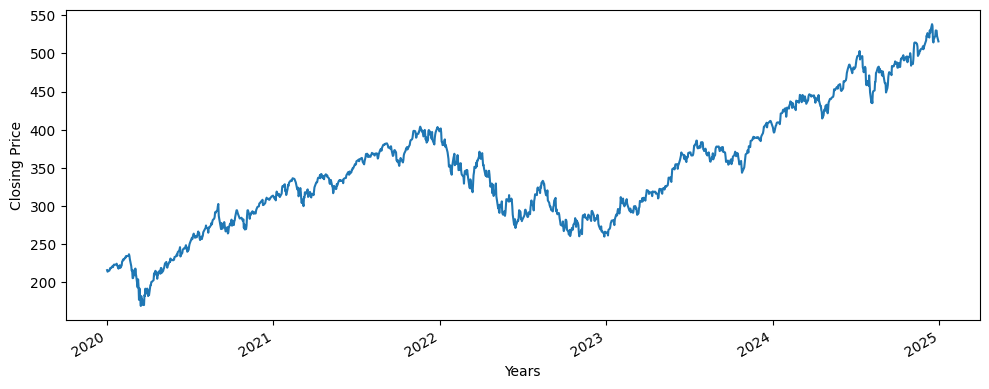

In [ ]:
# Visualize 5 years of stock price data
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df['date'], df['close'])
ax.set_xlabel('Years')
ax.set_ylabel('Closing Price')
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

Through the above graph, we can understand the overall trend over the past 5 years. Overall, there is an upward trend, but there are sharp declines in the early part of 2020 and between 2022 and 2023. To examine this in more detail, let's look at the graphs for each year.

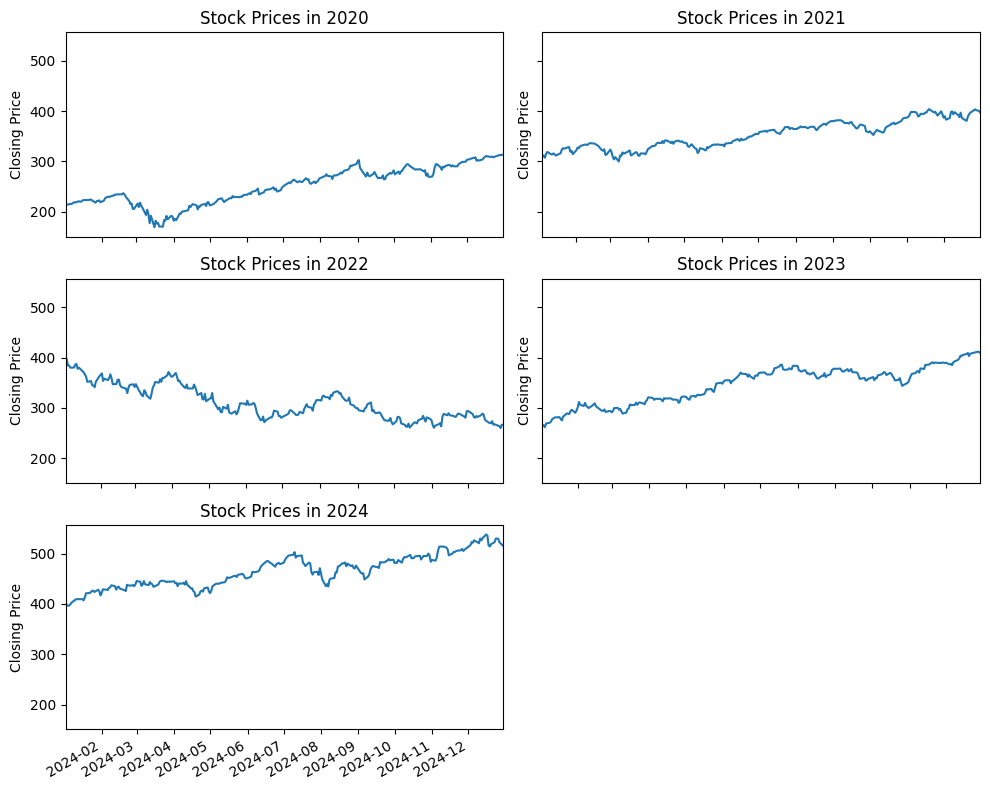

In [ ]:
# Visualizing 5 years of data using a 3x2 subplot layout
fig, axes = plt.subplots(3, 2, figsize=(10, 8), sharex=False, sharey=True)

years = [2020, 2021, 2022, 2023, 2024]

# Plot each year's data
for i, year in enumerate(years):
    row, col = i // 2, i % 2
    df_year = df[df['date'].dt.year == year]

    # Plot only if data is available
    if not df_year.empty:
        axes[row, col].plot(df_year['date'], df_year['close'])
        axes[row, col].set_title(f"Stock Prices in {year}")
        axes[row, col].set_ylabel("Closing Price")

        # Set X-axis limits from the start to the end of the year
        axes[row, col].set_xlim(df_year['date'].min(), df_year['date'].max())

# Remove empty subplots if any
for i in range(len(years), 6):
    fig.delaxes(axes[i // 2, i % 2])

# Automatically adjust X-axis date format
fig.autofmt_xdate()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


### 📈 Key Events Impacting the Stock Market in 2020, 2022

- **2020.02**  
**COVID-19 pandemic** broke out, increasing global uncertainty and causing a sharp decline in stock prices.
Later, a rebound occurred as government stimulus measures and central bank interest rate cuts helped the stock market recover.

- **2022.02**   
**Russia vs. Ukraine war** began.
Energy and commodity prices soared, leading to worsening global economic inflation.
Increased uncertainty caused stock prices to drop.

- **2022.03**   
**Fed's interest rate hike (0.25%) began**, aimed at controlling inflation, but it negatively impacted the stock market.

- **2022.06, 07, 09**   
**Fed's interest rate hikes (each 0.75%)** were implemented.
The June and July rate hikes especially caused significant market volatility, further deepening the downward trend in the stock market.

### 3.3. Seasonality, Yearly Trend

To understand the seasonality, trends, and patterns in the stock market over the past five years, we calculate the monthly and yearly average closing prices.

**Seasonality Check**  
The stock market can exhibit recurring patterns at specific times of the year. For example, phenomena like the Year-end Rally or low trading volumes during the summer are commonly observed in the market. By calculating the average closing price per month, we can identify which months tend to show bullish or bearish trends.

**Yearly Trend Analysis**  
To understand the long-term market trends, we conduct a yearly average closing price analysis. This allows us to assess the overall market flow in each year and identify periods of significant volatility.

In [ ]:
# Extract the month and year from the 'Date' column
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year


# Calculate the mean close price per month
monthly_mean = df.groupby(['month'])['close'].mean().reset_index()

# Calculate the mean close price per year
yearly_mean = df.groupby(['year'])['close'].mean().reset_index()

print("\n<Monthly Mean Close Price> \n", monthly_mean)
print("\n<Yearly Mean Close Price> \n", yearly_mean)


<Monthly Mean Close Price> 
     month       close
0       1  320.169998
1       2  329.128750
2       3  316.779909
3       4  327.599127
4       5  328.470763
5       6  338.271619
6       7  355.802095
7       8  360.470450
8       9  354.570971
9      10  356.928442
10     11  369.487185
11     12  378.381808

<Yearly Mean Close Price> 
    year       close
0  2020  250.558380
1  2021  353.040874
2  2022  310.738645
3  2023  345.773800
4  2024  464.681512


#### 3.3.1 Seasonality Check

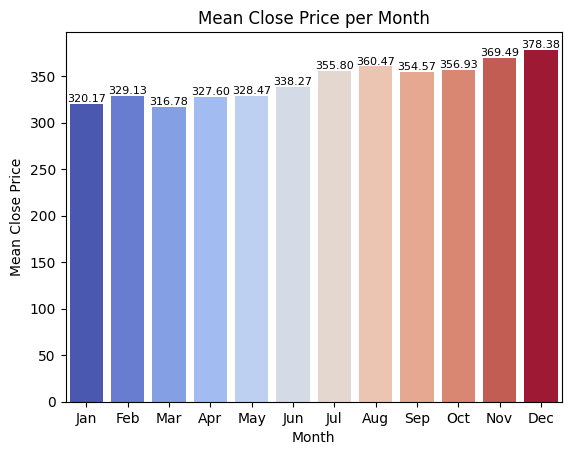

In [ ]:
# Plot the mean close price per month using a Seaborn bar chart
ax = sns.barplot(data=monthly_mean, x='month', y='close', hue='month', palette='coolwarm', legend=False)

plt.title('Mean Close Price per Month')
plt.xlabel('Month')
plt.ylabel('Mean Close Price')

# X-axis ticks for each month
plt.xticks(range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Adding the value labels on top of bars
for bars in ax.containers:
    ax.bar_label(bars, fontsize=8, fmt='%.2f')

plt.show()

### 📈 **Monthly Seasonality (Strong Bullish/Bearish Periods)**

**Bullish in the Second Half** (July to December)  
From June (338) to December (378), a +11.8% increase.  
Especially a sharp rise from November (369) to December (378) → aligns with the "Year-end Rally" phenomenon.

**Volatility in the First Half** (January to March)  
From January (320) to March (316), a -1.3% decrease → no sign of the "January Effect" (traditionally a bullish January).

**Summer Stagnation** (July to September)  
From July (355) to September (354), a slight decline of -0.3%.

#### 3.3.2 Yearly Trend Analysis

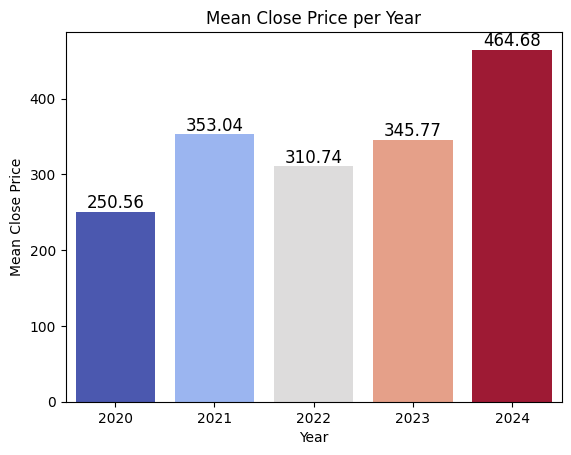

In [ ]:
lst_year= yearly_mean['year'].tolist()

# Plot the mean close price per month using a Seaborn bar chart
ax = sns.barplot(data=yearly_mean, x='year', y='close', palette='coolwarm', hue = 'year', legend = False)

plt.title('Mean Close Price per Year')
plt.xlabel('Year')
plt.ylabel('Mean Close Price')

plt.xticks(range(0, len(lst_year)), labels=lst_year)

for bars in ax.containers:
     ax.bar_label(bars, fontsize=12, fmt='%.2f')

plt.show()

### 📊 **Annual Trend (5-Year Long-Term Performance)**

Annual Average Return from 2020 to 2024: +16.7% (250 → 464)

**2021:** +40.9% (250 → 353) → Tech sector boom

**2022:** -12.0% (353 → 310) → Impact of interest rate hikes

**2024:** +34.4% (345 → 464) → AI rally driving growth

## 4. Feature Engineering

- Moving Averages (MA): Smooths stock price movements to identify short-term and long-term trends (e.g., 5-day, 20-day, 50-day, 200-day).
- Relative Strength Index (RSI): Measures whether a stock is overbought or oversold, reflecting price momentum.
- MACD (Moving Average Convergence Divergence): Identifies trend changes and momentum using two moving averages.
- Bollinger Bands: Measures price volatility and deviation from the average price.
- Volume Volatility: Analyzes the relationship between price and trading volume to predict market movements.
- Open-Close Difference: Indicates daily price volatility and potential trend strength.
- High-Low Difference: Represents intraday volatility, with larger differences signaling higher fluctuations.
- High-Open Difference (High_Open_Diff): Measures how much the high price (high) has increased compared to the opening price (open) during the day.
- Low-Close Difference (Low_Close_Diff): Measures how much the closing price (close) has recovered compared to the low price (low) during the day.

In [ ]:
# 1. Moving Average (MA)
df['MA_5'] = df['close'].rolling(window=5).mean()  # 5-day moving average
df['MA_20'] = df['close'].rolling(window=20).mean()  # 20-day moving average
df['MA_50'] = df['close'].rolling(window=50).mean()  # 50-day moving average

# 2. Relative Strength Index (RSI)
delta = df['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# 3. MACD (Moving Average Convergence Divergence)
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()  # 12-day exponential moving average
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()  # 26-day exponential moving average
df['MACD'] = df['EMA_12'] - df['EMA_26']

# 4. Bollinger Bands
df['Bollinger_Upper'] = df['MA_20'] + 2 * df['close'].rolling(window=20).std()
df['Bollinger_Lower'] = df['MA_20'] - 2 * df['close'].rolling(window=20).std()

# 5. Volume
df['Volume_MA_20'] = df['volume'].rolling(window=20).mean()  # 20-day moving average of volume

# 6. Open-Close, High-Low Difference
df['Open_Close_Diff'] = df['open'] - df['close']
df['High_Low_Diff'] = df['high'] - df['low']

# 8. High-Open Difference, Low-Close Difference
df['High_Open_Diff'] = df['high'] - df['open']
df['Low_Close_Diff'] = df['low'] - df['close']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1257 non-null   datetime64[ns]
 1   adj close        1257 non-null   float64       
 2   close            1257 non-null   float64       
 3   high             1257 non-null   float64       
 4   low              1257 non-null   float64       
 5   open             1257 non-null   float64       
 6   volume           1257 non-null   int64         
 7   month            1257 non-null   int32         
 8   year             1257 non-null   int32         
 9   MA_5             1253 non-null   float64       
 10  MA_20            1238 non-null   float64       
 11  MA_50            1208 non-null   float64       
 12  RSI              1244 non-null   float64       
 13  EMA_12           1257 non-null   float64       
 14  EMA_26           1257 non-null   float64

## Modeling

### 1. Baseline Model for benchmark

In [ ]:
### Moving Average Model : Linear

In [ ]:
# Calculate 5-day Moving Average (MA_5)
df['MA_5'] = df['close'].rolling(window=5).mean()

# Use the 5-day Moving Average as the baseline model's prediction
# Since we want to predict the next day's closing price, shift the MA_5 by 1 day
df['predicted_close_ma'] = df['MA_5'].shift(1)

# Remove the NaN values caused by the shift
df = df.dropna(subset=['predicted_close_ma'])

# Define the features and target for the MA model
X_baseline = df[['MA_5']]  # Using the MA_5 as the feature
y_baseline = df['close']   # Actual close prices are the target

# Train-test split
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline, y_baseline, test_size=0.2, random_state=42)

# Train a model (Linear Regression)
from sklearn.linear_model import LinearRegression

baseline_model = LinearRegression()
baseline_model.fit(X_train_baseline, y_train_baseline)

# Prediction
y_pred_baseline = baseline_model.predict(X_test_baseline)

# Evaluate the baseline model
mae_baseline = mean_absolute_error(y_test_baseline, y_pred_baseline)
print(f"Baseline MAE (Moving Average): {mae_baseline}")

Baseline MAE (Moving Average): 4.038859610248214


### 2. XGBoost

Mean Absolute Error: 2.803388488769531


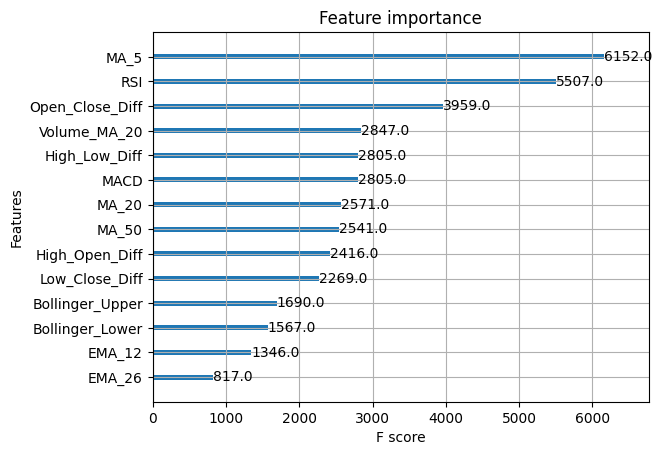

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# Fill missing values
df.ffill(inplace=True)

# Define the features and target variable
# Use the technical indicators (excluding date and adj close)
features = ['MA_5', 'MA_20', 'MA_50', 'RSI', 'EMA_12', 'EMA_26', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower',
            'Volume_MA_20', 'Open_Close_Diff', 'High_Low_Diff', 'High_Open_Diff', 'Low_Close_Diff']
target = 'close'

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model (with tuned hyperparameters)
model = xgb.XGBRegressor(
    n_estimators=1000, #EX
    learning_rate=0.01, #EX
    max_depth=6, #EX
    subsample=0.8,#EX
    colsample_bytree=0.8, #EX
    random_state=42
)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# plot feature importance
xgb.plot_importance(model, importance_type='weight')
plt.show()

### 3. LSTM

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.1190 - val_loss: 0.0041
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0043 - val_loss: 8.9976e-04
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0034 - val_loss: 8.8754e-04
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0035 - val_loss: 8.7551e-04
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0037 - val_loss: 8.8787e-04
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0033 - val_loss: 0.0018


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


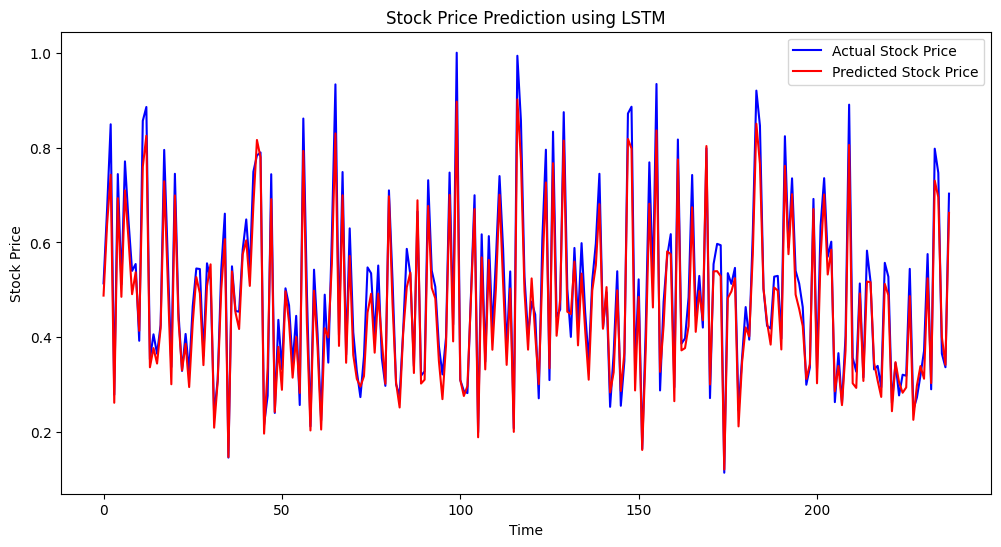

LSTM MAE: 0.03614451324220565


In [ ]:
# Feature Scaling (Scaling values between 0 and 1 for LSTM input)
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize only the 'close' (since we will use it as the target)
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

# Create time-series dataset
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])  # X contains the data for the window size
        y.append(data[i, 0])  # y is the next day's closing price
    return np.array(X), np.array(y)

window_size = 60  # Use a window of 60 days to predict the next day
X, y = create_dataset(scaled_data, window_size)

# Reshape data (LSTM input requires 3D array)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # (samples, timesteps, features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()

# LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Fully connected layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(y_pred, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Evaluate the model (Calculate MAE)
from sklearn.metrics import mean_absolute_error
mae_lstm = mean_absolute_error(y_test, y_pred)
print(f"LSTM MAE: {mae_lstm}")